In [1]:
import pandas as pd
from swarm_sim import *
from metrics import *
import random 
import nbimporter
from metrics import path_disparity, path_redundancy, routing_cost, flow_robustness, network_efficiency, critical_nodes
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

### extraction Data 

In [2]:
df = pd.read_csv("Traces.csv", header=None)  

# Créer les noms de colonnes pour le temps
time_cols = [str(i+1) for i in range(10000)]
df.columns = time_cols

#générer les noms des lignes (cordonnées des satellites):
coord_names = []
for i in range(1, 101):  # 100 satellites
    coord_names.append(f"satx{i}")
    coord_names.append(f"saty{i}")
    coord_names.append(f"satz{i}")
df["coords"] = coord_names
df = df.set_index("coords")

dft = df.transpose()  # maintenant chaque ligne = un instant

### convert to swarm

In [11]:
connection_range = 60000
portee1 =20000
portee2=40000
portee3= 60000
nanosat_count = 100
max_temps = 100  # pour test rapide
t_attack = 50 

#stocker les résultats pour chaque algo
resultats_FFD = []
resultats_MIRW = []
resultats_RND = []

# Liste des satellites encore actifs
satellites_actifs = set(range(1, nanosat_count + 1))

algos = ["FFD", "RND", "MIRW"]

for algo in algos : 
    print("Traitement de l’algorithme :", algo)
    resultats=[]
    for t in tqdm(range(max_temps), desc="Simulation en cours"):
        print(f"\n--- Temps t = {t} ---")
        coords = dft.iloc[t]
        nodes = []
        
        # Créer les objets Node
        for i in satellites_actifs:
            x = coords[f'satx{i}']
            y = coords[f'saty{i}']
            z = coords[f'satz{i}']
            nodes.append(Node(id=i, x=x, y=y, z=z))
    
        swarm = Swarm(connection_range=connection_range, nodes=nodes)
    
        # Créer un graphe pondéré
        G = nx.Graph()
        for node in nodes:
            G.add_node(node.id)
    
        # Ajouter les arêtes avec poids selon la distance
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                dist = nodes[i].compute_dist(nodes[j])
                if dist <= portee1:
                    weight = 1
                elif dist <= portee2:
                    weight = 2
                elif dist <= portee3:
                    weight = 3
                else:
                    continue  
                G.add_edge(nodes[i].id, nodes[j].id, weight=weight)
            # ----- Étape 1 : Métriques de base (graphe non divisé) -----
        metriques_avant = {
            "time": t,
            "algo": "none",
            "attack": "none",
            "efficacite":network_efficiency(G),
            "cout": routing_cost(G),
            "robustesse": flow_robustness(G),
            "redondance": 0, #path_redundancy(G),
            "disparite": 0, #path_disparity(G),
            "criticite": critical_nodes(G)
        }
        resultats.append(metriques_avant)
        print("  > Métriques avant division calculées.")
        # ----- Étape 2 : Pour chaque algorithme de division -----
        if algo == "RND" :
            groupes = swarm.RND(n=10)
        elif algo == "MIRW" :
            groupes = swarm.MIRW(n=10)
        else :
            groupes = swarm.FFD(n=10)
      
        # Construire group_dict
        group_dict = {}
        for group_id, sub_swarm in groupes.items():
            for n in sub_swarm.nodes:
                group_dict[n.id] = group_id
    
        # ----- Métriques post-division -----
        metriques_div = {
            "time": t,
            "algo": algo,
            "attack": "none",
            "efficacite": network_efficiency(G, divided=True, group_dict=group_dict),
            "cout": routing_cost(G, divided=True, group_dict=group_dict),
            "robustesse": flow_robustness(G, divided=True, group_dict=group_dict),
            "redondance": 0, #path_redundancy(G, divided=True, group_dict=group_dict),
            "disparite": 0, #path_disparity(G, divided=True, group_dict=group_dict),
             "criticite": critical_nodes(G, divided=True, group_dict=group_dict)
        }
        
        resultats.append(metriques_div)
        print("  > Métriques après division calculées.")
       
        # ----- Étape 3 : Appliquer les attaques -----
        attack_type = "none"
        nb_noeuds_supprimes = 10
        G_copy = G.copy()
        
        if t == t_attack:
            attack_type = "random"
            if attack_type == "cible":
                BC = node_criticality(G_copy, divided=True, group_dict=group_dict)
            if attack_type == "random":
                nodes_to_remove = random.sample(list(G_copy.nodes), min(nb_noeuds_supprimes, len(G_copy)))
            else:  # attaque ciblée
                nodes_to_remove = sorted(BC, key=BC.get, reverse=True)[:nb_noeuds_supprimes]
    
            G_copy.remove_nodes_from(nodes_to_remove)
    
            # Retirer les satellites attaqués de la simulation
            satellites_actifs.difference_update(nodes_to_remove)
    
            # ----- Métriques post-attaque -----
        metriques_attaque = {
                "time": t,
                "algo": algo,
                "attack": attack_type,
                "efficacite": network_efficiency(G_copy, divided=True, group_dict=group_dict),
                "cout": routing_cost(G_copy, divided=True, group_dict=group_dict),
                "robustesse": flow_robustness(G_copy, divided=True, group_dict=group_dict),
                "redondance": 0, #path_redundancy(G_copy, divided=True, group_dict=group_dict),
                "disparite": 0, #path_disparity(G_copy, divided=True, group_dict=group_dict),
                "criticite": critical_nodes(G_copy, divided=True, group_dict=group_dict)
            }
        
        resultats.append(metriques_attaque)
        print("  > Métriques après attaque calculées.")
        if algo == "RND" :
            resultats_RND = resultats
        elif algo == "MIRW" :
            resultats_MIRW = resultats 
        else :  
            resultats_FFD = resultats 


Traitement de l’algorithme : FFD


Simulation en cours:   1%|▌                                                            | 1/100 [00:00<00:19,  5.10it/s]


--- Temps t = 0 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 1 ---


Simulation en cours:   2%|█▏                                                           | 2/100 [00:00<00:19,  4.98it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 2 ---
  > Métriques avant division calculées.


Simulation en cours:   3%|█▊                                                           | 3/100 [00:00<00:19,  5.08it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 3 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   5%|███                                                          | 5/100 [00:00<00:18,  5.18it/s]

  > Métriques après attaque calculées.

--- Temps t = 4 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:   6%|███▋                                                         | 6/100 [00:01<00:18,  5.18it/s]


--- Temps t = 5 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:   7%|████▎                                                        | 7/100 [00:01<00:18,  5.01it/s]


--- Temps t = 6 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 7 ---


Simulation en cours:   8%|████▉                                                        | 8/100 [00:01<00:18,  4.99it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 8 ---
  > Métriques avant division calculées.


Simulation en cours:   9%|█████▍                                                       | 9/100 [00:01<00:18,  4.94it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 9 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  11%|██████▌                                                     | 11/100 [00:02<00:18,  4.90it/s]

  > Métriques après attaque calculées.

--- Temps t = 10 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  12%|███████▏                                                    | 12/100 [00:02<00:17,  4.93it/s]


--- Temps t = 11 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  13%|███████▊                                                    | 13/100 [00:02<00:18,  4.83it/s]


--- Temps t = 12 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 13 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  15%|█████████                                                   | 15/100 [00:03<00:17,  4.80it/s]

  > Métriques après attaque calculées.

--- Temps t = 14 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  16%|█████████▌                                                  | 16/100 [00:03<00:17,  4.83it/s]


--- Temps t = 15 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 16 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  17%|██████████▏                                                 | 17/100 [00:03<00:17,  4.86it/s]

  > Métriques après attaque calculées.

--- Temps t = 17 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  18%|██████████▊                                                 | 18/100 [00:03<00:17,  4.73it/s]

  > Métriques après attaque calculées.

--- Temps t = 18 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  20%|████████████                                                | 20/100 [00:04<00:17,  4.64it/s]


--- Temps t = 19 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  21%|████████████▌                                               | 21/100 [00:04<00:16,  4.76it/s]


--- Temps t = 20 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 21 ---


Simulation en cours:  22%|█████████████▏                                              | 22/100 [00:04<00:15,  4.90it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 22 ---
  > Métriques avant division calculées.


Simulation en cours:  23%|█████████████▊                                              | 23/100 [00:04<00:15,  4.94it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 23 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  25%|███████████████                                             | 25/100 [00:05<00:15,  4.92it/s]

  > Métriques après attaque calculées.

--- Temps t = 24 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  26%|███████████████▌                                            | 26/100 [00:05<00:14,  4.95it/s]


--- Temps t = 25 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 26 ---


Simulation en cours:  27%|████████████████▏                                           | 27/100 [00:05<00:15,  4.82it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 27 ---


Simulation en cours:  29%|█████████████████▍                                          | 29/100 [00:05<00:14,  4.95it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 28 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 29 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  31%|██████████████████▌                                         | 31/100 [00:06<00:14,  4.77it/s]

  > Métriques après attaque calculées.

--- Temps t = 30 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 31 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  32%|███████████████████▏                                        | 32/100 [00:06<00:14,  4.71it/s]

  > Métriques après attaque calculées.

--- Temps t = 32 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  34%|████████████████████▍                                       | 34/100 [00:06<00:13,  4.88it/s]


--- Temps t = 33 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  35%|█████████████████████                                       | 35/100 [00:07<00:12,  5.05it/s]


--- Temps t = 34 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 35 ---


Simulation en cours:  36%|█████████████████████▌                                      | 36/100 [00:07<00:12,  4.93it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 36 ---
  > Métriques avant division calculées.


Simulation en cours:  37%|██████████████████████▏                                     | 37/100 [00:07<00:12,  5.01it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 37 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  38%|██████████████████████▊                                     | 38/100 [00:07<00:12,  4.87it/s]

  > Métriques après attaque calculées.

--- Temps t = 38 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  40%|████████████████████████                                    | 40/100 [00:08<00:12,  4.74it/s]

  > Métriques après attaque calculées.

--- Temps t = 39 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  41%|████████████████████████▌                                   | 41/100 [00:08<00:12,  4.77it/s]


--- Temps t = 40 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 41 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  42%|█████████████████████████▏                                  | 42/100 [00:08<00:12,  4.69it/s]

  > Métriques après attaque calculées.

--- Temps t = 42 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  43%|█████████████████████████▊                                  | 43/100 [00:08<00:12,  4.65it/s]

  > Métriques après attaque calculées.

--- Temps t = 43 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  45%|███████████████████████████                                 | 45/100 [00:09<00:11,  4.65it/s]

  > Métriques après attaque calculées.

--- Temps t = 44 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  46%|███████████████████████████▌                                | 46/100 [00:09<00:11,  4.72it/s]


--- Temps t = 45 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 46 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  47%|████████████████████████████▏                               | 47/100 [00:09<00:11,  4.74it/s]

  > Métriques après attaque calculées.

--- Temps t = 47 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  49%|█████████████████████████████▍                              | 49/100 [00:10<00:10,  4.71it/s]


--- Temps t = 48 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  50%|██████████████████████████████                              | 50/100 [00:10<00:10,  4.70it/s]


--- Temps t = 49 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 50 ---


Simulation en cours:  51%|██████████████████████████████▌                             | 51/100 [00:10<00:10,  4.82it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 51 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  53%|███████████████████████████████▊                            | 53/100 [00:10<00:08,  5.55it/s]

  > Métriques après attaque calculées.

--- Temps t = 52 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 53 ---


Simulation en cours:  55%|█████████████████████████████████                           | 55/100 [00:11<00:07,  5.84it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 54 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 55 ---


Simulation en cours:  56%|█████████████████████████████████▌                          | 56/100 [00:11<00:07,  6.02it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 56 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  58%|██████████████████████████████████▊                         | 58/100 [00:11<00:07,  5.84it/s]


--- Temps t = 57 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 58 ---


Simulation en cours:  59%|███████████████████████████████████▍                        | 59/100 [00:11<00:06,  6.11it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 59 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  61%|████████████████████████████████████▌                       | 61/100 [00:12<00:06,  6.28it/s]


--- Temps t = 60 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 61 ---


Simulation en cours:  63%|█████████████████████████████████████▊                      | 63/100 [00:12<00:05,  6.28it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 62 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 63 ---


Simulation en cours:  64%|██████████████████████████████████████▍                     | 64/100 [00:12<00:05,  6.26it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 64 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  66%|███████████████████████████████████████▌                    | 66/100 [00:12<00:05,  6.51it/s]


--- Temps t = 65 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 66 ---


Simulation en cours:  67%|████████████████████████████████████████▏                   | 67/100 [00:13<00:05,  6.48it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 67 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  69%|█████████████████████████████████████████▍                  | 69/100 [00:13<00:04,  6.22it/s]


--- Temps t = 68 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 69 ---


Simulation en cours:  70%|██████████████████████████████████████████                  | 70/100 [00:13<00:04,  6.28it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 70 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  72%|███████████████████████████████████████████▏                | 72/100 [00:13<00:04,  6.03it/s]

  > Métriques après attaque calculées.

--- Temps t = 71 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 72 ---


Simulation en cours:  73%|███████████████████████████████████████████▊                | 73/100 [00:14<00:04,  6.22it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 73 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  75%|█████████████████████████████████████████████               | 75/100 [00:14<00:04,  6.05it/s]


--- Temps t = 74 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 75 ---


Simulation en cours:  77%|██████████████████████████████████████████████▏             | 77/100 [00:14<00:03,  6.08it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 76 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  78%|██████████████████████████████████████████████▊             | 78/100 [00:14<00:03,  5.84it/s]


--- Temps t = 77 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 78 ---


Simulation en cours:  79%|███████████████████████████████████████████████▍            | 79/100 [00:15<00:03,  5.89it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 79 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  81%|████████████████████████████████████████████████▌           | 81/100 [00:15<00:03,  6.01it/s]


--- Temps t = 80 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 81 ---


Simulation en cours:  83%|█████████████████████████████████████████████████▊          | 83/100 [00:15<00:02,  5.98it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 82 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 83 ---


Simulation en cours:  85%|███████████████████████████████████████████████████         | 85/100 [00:16<00:02,  6.30it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 84 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  86%|███████████████████████████████████████████████████▌        | 86/100 [00:16<00:02,  6.42it/s]


--- Temps t = 85 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 86 ---


Simulation en cours:  87%|████████████████████████████████████████████████████▏       | 87/100 [00:16<00:01,  6.51it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 87 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  89%|█████████████████████████████████████████████████████▍      | 89/100 [00:16<00:01,  6.56it/s]


--- Temps t = 88 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 89 ---


Simulation en cours:  91%|██████████████████████████████████████████████████████▌     | 91/100 [00:16<00:01,  6.53it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 90 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 91 ---


Simulation en cours:  92%|███████████████████████████████████████████████████████▏    | 92/100 [00:17<00:01,  6.49it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 92 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  94%|████████████████████████████████████████████████████████▍   | 94/100 [00:17<00:00,  6.36it/s]


--- Temps t = 93 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 94 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  96%|█████████████████████████████████████████████████████████▌  | 96/100 [00:17<00:00,  6.27it/s]

  > Métriques après attaque calculées.

--- Temps t = 95 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 96 ---


Simulation en cours:  97%|██████████████████████████████████████████████████████████▏ | 97/100 [00:17<00:00,  6.37it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 97 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  99%|███████████████████████████████████████████████████████████▍| 99/100 [00:18<00:00,  6.41it/s]


--- Temps t = 98 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 99 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours: 100%|███████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.44it/s]


  > Métriques après attaque calculées.
Traitement de l’algorithme : RND


Simulation en cours:   1%|▌                                                            | 1/100 [00:00<00:16,  6.15it/s]


--- Temps t = 0 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 1 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   3%|█▊                                                           | 3/100 [00:00<00:15,  6.17it/s]

  > Métriques après attaque calculées.

--- Temps t = 2 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 3 ---


Simulation en cours:   5%|███                                                          | 5/100 [00:00<00:16,  5.89it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 4 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:   6%|███▋                                                         | 6/100 [00:01<00:15,  6.05it/s]


--- Temps t = 5 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 6 ---


Simulation en cours:   8%|████▉                                                        | 8/100 [00:01<00:15,  6.11it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 7 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 8 ---


Simulation en cours:   9%|█████▍                                                       | 9/100 [00:01<00:14,  6.16it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 9 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  11%|██████▌                                                     | 11/100 [00:01<00:14,  6.24it/s]


--- Temps t = 10 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 11 ---


Simulation en cours:  13%|███████▊                                                    | 13/100 [00:02<00:13,  6.25it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 12 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 13 ---


Simulation en cours:  14%|████████▍                                                   | 14/100 [00:02<00:13,  6.34it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 14 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  16%|█████████▌                                                  | 16/100 [00:02<00:13,  6.45it/s]

  > Métriques après attaque calculées.

--- Temps t = 15 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 16 ---
  > Métriques avant division calculées.


Simulation en cours:  18%|██████████▊                                                 | 18/100 [00:02<00:12,  6.44it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 17 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  19%|███████████▍                                                | 19/100 [00:03<00:12,  6.53it/s]


--- Temps t = 18 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 19 ---


Simulation en cours:  21%|████████████▌                                               | 21/100 [00:03<00:11,  6.66it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 20 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 21 ---


Simulation en cours:  22%|█████████████▏                                              | 22/100 [00:03<00:12,  6.41it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 22 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  24%|██████████████▍                                             | 24/100 [00:03<00:11,  6.50it/s]


--- Temps t = 23 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 24 ---


Simulation en cours:  26%|███████████████▌                                            | 26/100 [00:04<00:11,  6.48it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 25 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 26 ---


Simulation en cours:  28%|████████████████▊                                           | 28/100 [00:04<00:11,  6.51it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 27 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 28 ---


Simulation en cours:  30%|██████████████████                                          | 30/100 [00:04<00:10,  6.57it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 29 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 30 ---


Simulation en cours:  32%|███████████████████▏                                        | 32/100 [00:05<00:10,  6.58it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 31 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  33%|███████████████████▊                                        | 33/100 [00:05<00:10,  6.40it/s]


--- Temps t = 32 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 33 ---


Simulation en cours:  34%|████████████████████▍                                       | 34/100 [00:05<00:10,  6.50it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 34 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  36%|█████████████████████▌                                      | 36/100 [00:05<00:09,  6.50it/s]


--- Temps t = 35 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 36 ---


Simulation en cours:  38%|██████████████████████▊                                     | 38/100 [00:05<00:09,  6.58it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 37 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  39%|███████████████████████▍                                    | 39/100 [00:06<00:09,  6.43it/s]


--- Temps t = 38 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 39 ---


Simulation en cours:  41%|████████████████████████▌                                   | 41/100 [00:06<00:09,  6.42it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 40 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  43%|█████████████████████████▊                                  | 43/100 [00:06<00:08,  6.44it/s]


--- Temps t = 41 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 42 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  44%|██████████████████████████▍                                 | 44/100 [00:06<00:08,  6.49it/s]


--- Temps t = 43 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 44 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  46%|███████████████████████████▌                                | 46/100 [00:07<00:08,  6.44it/s]

  > Métriques après attaque calculées.

--- Temps t = 45 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 46 ---


Simulation en cours:  47%|████████████████████████████▏                               | 47/100 [00:07<00:08,  6.43it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 47 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  49%|█████████████████████████████▍                              | 49/100 [00:07<00:08,  6.28it/s]


--- Temps t = 48 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 49 ---


Simulation en cours:  51%|██████████████████████████████▌                             | 51/100 [00:07<00:07,  6.42it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 50 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  53%|███████████████████████████████▊                            | 53/100 [00:08<00:06,  7.22it/s]


--- Temps t = 51 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 52 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  54%|████████████████████████████████▍                           | 54/100 [00:08<00:06,  7.28it/s]


--- Temps t = 53 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 54 ---


Simulation en cours:  56%|█████████████████████████████████▌                          | 56/100 [00:08<00:05,  7.75it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 55 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 56 ---
  > Métriques avant division calculées.


Simulation en cours:  58%|██████████████████████████████████▊                         | 58/100 [00:08<00:05,  8.13it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 57 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 58 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  60%|████████████████████████████████████                        | 60/100 [00:09<00:04,  8.34it/s]

  > Métriques après attaque calculées.

--- Temps t = 59 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 60 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  62%|█████████████████████████████████████▏                      | 62/100 [00:09<00:04,  8.27it/s]

  > Métriques après attaque calculées.

--- Temps t = 61 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 62 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  64%|██████████████████████████████████████▍                     | 64/100 [00:09<00:04,  8.63it/s]

  > Métriques après attaque calculées.

--- Temps t = 63 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 64 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  66%|███████████████████████████████████████▌                    | 66/100 [00:09<00:04,  8.04it/s]

  > Métriques après attaque calculées.

--- Temps t = 65 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 66 ---
  > Métriques avant division calculées.


Simulation en cours:  68%|████████████████████████████████████████▊                   | 68/100 [00:10<00:03,  8.45it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 67 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 68 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  70%|██████████████████████████████████████████                  | 70/100 [00:10<00:03,  8.66it/s]

  > Métriques après attaque calculées.

--- Temps t = 69 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 70 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  73%|███████████████████████████████████████████▊                | 73/100 [00:10<00:03,  8.78it/s]


--- Temps t = 71 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 72 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  74%|████████████████████████████████████████████▍               | 74/100 [00:10<00:02,  8.88it/s]


--- Temps t = 73 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 74 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  76%|█████████████████████████████████████████████▌              | 76/100 [00:10<00:02,  8.66it/s]


--- Temps t = 75 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 76 ---
  > Métriques avant division calculées.


Simulation en cours:  78%|██████████████████████████████████████████████▊             | 78/100 [00:11<00:02,  8.36it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 77 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 78 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  80%|████████████████████████████████████████████████            | 80/100 [00:11<00:02,  7.69it/s]

  > Métriques après attaque calculées.

--- Temps t = 79 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 80 ---
  > Métriques avant division calculées.


Simulation en cours:  82%|█████████████████████████████████████████████████▏          | 82/100 [00:11<00:02,  8.14it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 81 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 82 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  84%|██████████████████████████████████████████████████▍         | 84/100 [00:11<00:01,  8.56it/s]

  > Métriques après attaque calculées.

--- Temps t = 83 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 84 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  87%|████████████████████████████████████████████████████▏       | 87/100 [00:12<00:01,  8.80it/s]


--- Temps t = 85 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 86 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  88%|████████████████████████████████████████████████████▊       | 88/100 [00:12<00:01,  8.39it/s]


--- Temps t = 87 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 88 ---
  > Métriques avant division calculées.


Simulation en cours:  90%|██████████████████████████████████████████████████████      | 90/100 [00:12<00:01,  8.50it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 89 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 90 ---
  > Métriques avant division calculées.


Simulation en cours:  92%|███████████████████████████████████████████████████████▏    | 92/100 [00:12<00:00,  8.33it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 91 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 92 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  94%|████████████████████████████████████████████████████████▍   | 94/100 [00:13<00:00,  8.25it/s]

  > Métriques après attaque calculées.

--- Temps t = 93 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 94 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  96%|█████████████████████████████████████████████████████████▌  | 96/100 [00:13<00:00,  8.38it/s]

  > Métriques après attaque calculées.

--- Temps t = 95 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 96 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  98%|██████████████████████████████████████████████████████████▊ | 98/100 [00:13<00:00,  8.46it/s]

  > Métriques après attaque calculées.

--- Temps t = 97 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 98 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours: 100%|███████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.24it/s]


  > Métriques après attaque calculées.

--- Temps t = 99 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.
Traitement de l’algorithme : MIRW


Simulation en cours:   0%|                                                                     | 0/100 [00:00<?, ?it/s]


--- Temps t = 0 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   1%|▌                                                            | 1/100 [00:00<00:10,  9.44it/s]

  > Métriques après attaque calculées.

--- Temps t = 1 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   2%|█▏                                                           | 2/100 [00:00<00:11,  8.38it/s]

  > Métriques après attaque calculées.

--- Temps t = 2 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   3%|█▊                                                           | 3/100 [00:00<00:11,  8.74it/s]

  > Métriques après attaque calculées.

--- Temps t = 3 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   4%|██▍                                                          | 4/100 [00:00<00:10,  8.73it/s]

  > Métriques après attaque calculées.

--- Temps t = 4 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   5%|███                                                          | 5/100 [00:00<00:10,  8.83it/s]

  > Métriques après attaque calculées.

--- Temps t = 5 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   6%|███▋                                                         | 6/100 [00:00<00:10,  8.92it/s]

  > Métriques après attaque calculées.

--- Temps t = 6 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   7%|████▎                                                        | 7/100 [00:00<00:10,  8.97it/s]

  > Métriques après attaque calculées.

--- Temps t = 7 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   8%|████▉                                                        | 8/100 [00:00<00:10,  8.61it/s]

  > Métriques après attaque calculées.

--- Temps t = 8 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   9%|█████▍                                                       | 9/100 [00:01<00:10,  8.83it/s]

  > Métriques après attaque calculées.

--- Temps t = 9 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  10%|██████                                                      | 10/100 [00:01<00:10,  8.41it/s]


--- Temps t = 10 ---
  > Métriques avant division calculées.


Simulation en cours:  11%|██████▌                                                     | 11/100 [00:01<00:10,  8.53it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 11 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  12%|███████▏                                                    | 12/100 [00:01<00:10,  8.53it/s]

  > Métriques après attaque calculées.

--- Temps t = 12 ---
  > Métriques avant division calculées.


Simulation en cours:  13%|███████▊                                                    | 13/100 [00:01<00:10,  8.64it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 13 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  14%|████████▍                                                   | 14/100 [00:01<00:10,  8.45it/s]

  > Métriques après attaque calculées.

--- Temps t = 14 ---
  > Métriques avant division calculées.


Simulation en cours:  15%|█████████                                                   | 15/100 [00:01<00:10,  8.46it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 15 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  16%|█████████▌                                                  | 16/100 [00:01<00:09,  8.45it/s]

  > Métriques après attaque calculées.

--- Temps t = 16 ---
  > Métriques avant division calculées.


Simulation en cours:  17%|██████████▏                                                 | 17/100 [00:01<00:09,  8.39it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 17 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  18%|██████████▊                                                 | 18/100 [00:02<00:09,  8.69it/s]

  > Métriques après attaque calculées.

--- Temps t = 18 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  19%|███████████▍                                                | 19/100 [00:02<00:09,  8.75it/s]


--- Temps t = 19 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  20%|████████████                                                | 20/100 [00:02<00:09,  8.86it/s]

  > Métriques après attaque calculées.

--- Temps t = 20 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  21%|████████████▌                                               | 21/100 [00:02<00:08,  8.82it/s]

  > Métriques après attaque calculées.

--- Temps t = 21 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  22%|█████████████▏                                              | 22/100 [00:02<00:08,  8.73it/s]

  > Métriques après attaque calculées.

--- Temps t = 22 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  23%|█████████████▊                                              | 23/100 [00:02<00:09,  8.46it/s]

  > Métriques après attaque calculées.

--- Temps t = 23 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  24%|██████████████▍                                             | 24/100 [00:02<00:08,  8.79it/s]


--- Temps t = 24 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  25%|███████████████                                             | 25/100 [00:02<00:08,  8.42it/s]

  > Métriques après attaque calculées.

--- Temps t = 25 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  26%|███████████████▌                                            | 26/100 [00:03<00:08,  8.69it/s]

  > Métriques après attaque calculées.

--- Temps t = 26 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  27%|████████████████▏                                           | 27/100 [00:03<00:08,  8.74it/s]


--- Temps t = 27 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  28%|████████████████▊                                           | 28/100 [00:03<00:08,  8.85it/s]

  > Métriques après attaque calculées.

--- Temps t = 28 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  29%|█████████████████▍                                          | 29/100 [00:03<00:08,  8.49it/s]

  > Métriques après attaque calculées.

--- Temps t = 29 ---
  > Métriques avant division calculées.


Simulation en cours:  30%|██████████████████                                          | 30/100 [00:03<00:08,  8.30it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 30 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  31%|██████████████████▌                                         | 31/100 [00:03<00:08,  8.52it/s]

  > Métriques après attaque calculées.

--- Temps t = 31 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  32%|███████████████████▏                                        | 32/100 [00:03<00:07,  8.53it/s]

  > Métriques après attaque calculées.

--- Temps t = 32 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  33%|███████████████████▊                                        | 33/100 [00:03<00:07,  8.70it/s]

  > Métriques après attaque calculées.

--- Temps t = 33 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  34%|████████████████████▍                                       | 34/100 [00:03<00:07,  8.64it/s]

  > Métriques après attaque calculées.

--- Temps t = 34 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  35%|█████████████████████                                       | 35/100 [00:04<00:07,  8.86it/s]


--- Temps t = 35 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  36%|█████████████████████▌                                      | 36/100 [00:04<00:07,  8.67it/s]

  > Métriques après attaque calculées.

--- Temps t = 36 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  37%|██████████████████████▏                                     | 37/100 [00:04<00:07,  8.51it/s]

  > Métriques après attaque calculées.

--- Temps t = 37 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  38%|██████████████████████▊                                     | 38/100 [00:04<00:07,  8.76it/s]


--- Temps t = 38 ---
  > Métriques avant division calculées.


Simulation en cours:  40%|████████████████████████                                    | 40/100 [00:04<00:07,  8.32it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 39 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 40 ---
  > Métriques avant division calculées.


Simulation en cours:  41%|████████████████████████▌                                   | 41/100 [00:04<00:07,  7.96it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 41 ---
  > Métriques avant division calculées.


Simulation en cours:  42%|█████████████████████████▏                                  | 42/100 [00:04<00:07,  8.22it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 42 ---


Simulation en cours:  43%|█████████████████████████▊                                  | 43/100 [00:05<00:06,  8.15it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 43 ---
  > Métriques avant division calculées.


Simulation en cours:  44%|██████████████████████████▍                                 | 44/100 [00:05<00:06,  8.37it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 44 ---
  > Métriques avant division calculées.


Simulation en cours:  45%|███████████████████████████                                 | 45/100 [00:05<00:06,  8.09it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 45 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  46%|███████████████████████████▌                                | 46/100 [00:05<00:06,  8.27it/s]

  > Métriques après attaque calculées.

--- Temps t = 46 ---
  > Métriques avant division calculées.


Simulation en cours:  47%|████████████████████████████▏                               | 47/100 [00:05<00:06,  7.99it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 47 ---
  > Métriques avant division calculées.


Simulation en cours:  48%|████████████████████████████▊                               | 48/100 [00:05<00:06,  7.96it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 48 ---
  > Métriques avant division calculées.


Simulation en cours:  49%|█████████████████████████████▍                              | 49/100 [00:05<00:06,  8.08it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 49 ---
  > Métriques avant division calculées.


Simulation en cours:  50%|██████████████████████████████                              | 50/100 [00:05<00:06,  7.98it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 50 ---
  > Métriques avant division calculées.


Simulation en cours:  51%|██████████████████████████████▌                             | 51/100 [00:06<00:06,  8.12it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 51 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 52 ---


Simulation en cours:  53%|███████████████████████████████▊                            | 53/100 [00:06<00:05,  9.31it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 53 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 54 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  55%|█████████████████████████████████                           | 55/100 [00:06<00:04,  9.83it/s]


--- Temps t = 55 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 56 ---


Simulation en cours:  57%|██████████████████████████████████▏                         | 57/100 [00:06<00:04, 10.38it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 57 ---


Simulation en cours:  59%|███████████████████████████████████▍                        | 59/100 [00:06<00:03, 10.82it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 58 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 59 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 60 ---


Simulation en cours:  61%|████████████████████████████████████▌                       | 61/100 [00:06<00:03, 11.24it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 61 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 62 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  63%|█████████████████████████████████████▊                      | 63/100 [00:07<00:03, 11.17it/s]


--- Temps t = 63 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 64 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  67%|████████████████████████████████████████▏                   | 67/100 [00:07<00:03, 10.36it/s]


--- Temps t = 65 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 66 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  69%|█████████████████████████████████████████▍                  | 69/100 [00:07<00:02, 10.34it/s]


--- Temps t = 67 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 68 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 69 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 70 ---


Simulation en cours:  73%|███████████████████████████████████████████▊                | 73/100 [00:08<00:02, 10.96it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 71 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 72 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  75%|█████████████████████████████████████████████               | 75/100 [00:08<00:02, 11.46it/s]


--- Temps t = 73 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 74 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 75 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 76 ---


Simulation en cours:  79%|███████████████████████████████████████████████▍            | 79/100 [00:08<00:01, 11.61it/s]

  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 77 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 78 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  81%|████████████████████████████████████████████████▌           | 81/100 [00:08<00:01, 11.30it/s]


--- Temps t = 79 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 80 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 81 ---
  > Métriques avant division calculées.


Simulation en cours:  83%|█████████████████████████████████████████████████▊          | 83/100 [00:08<00:01, 11.38it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 82 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 83 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 84 ---
  > Métriques avant division calculées.


Simulation en cours:  87%|████████████████████████████████████████████████████▏       | 87/100 [00:09<00:01, 12.04it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 85 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 86 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 87 ---
  > Métriques avant division calculées.


Simulation en cours:  89%|█████████████████████████████████████████████████████▍      | 89/100 [00:09<00:00, 11.98it/s]

  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 88 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 89 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 90 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  93%|███████████████████████████████████████████████████████▊    | 93/100 [00:09<00:00, 11.17it/s]


--- Temps t = 91 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 92 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  97%|██████████████████████████████████████████████████████████▏ | 97/100 [00:10<00:00, 11.68it/s]


--- Temps t = 93 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 94 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 95 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 96 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.


Simulation en cours:  99%|███████████████████████████████████████████████████████████▍| 99/100 [00:10<00:00, 11.54it/s]


--- Temps t = 97 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 98 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.
  > Métriques après attaque calculées.

--- Temps t = 99 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours: 100%|███████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.68it/s]

  > Métriques après attaque calculées.


In [12]:
# ========== Sauvegarde en CSV ==========
df_res1 = pd.DataFrame(resultats_FFD)
df_res1.to_csv("resultats_swarm_simulation_FFD.csv", index=False)

df_res2 = pd.DataFrame(resultats_RND)
df_res2.to_csv("resultats_swarm_simulation_RND.csv", index=False)

df_res3 = pd.DataFrame(resultats_MIRW)
df_res3.to_csv("resultats_swarm_simulation_MIRW.csv", index=False)


"""import os 
fichier1="resultats_swarm_simulation_FFD.csv"
if os.path.exists(fichier):
    print("existe")
else:
    print('existe pas')"""





'import os \nfichier1="resultats_swarm_simulation_FFD.csv"\nif os.path.exists(fichier):\n    print("existe")\nelse:\n    print(\'existe\xa0pas\')'

### Analyse des Resultats 

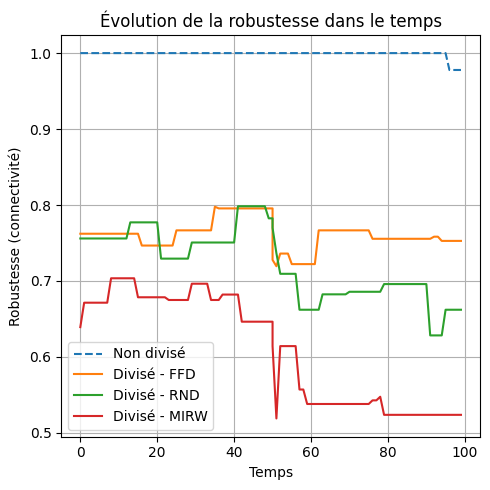

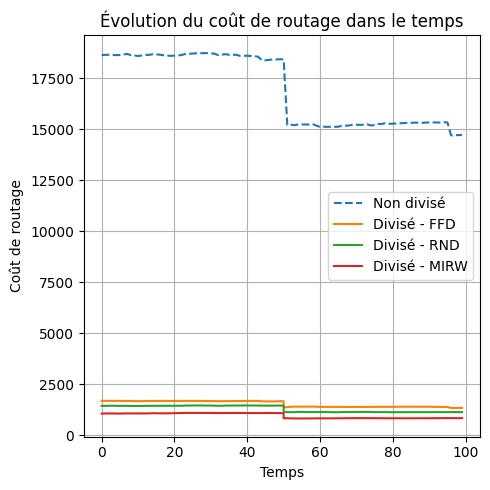

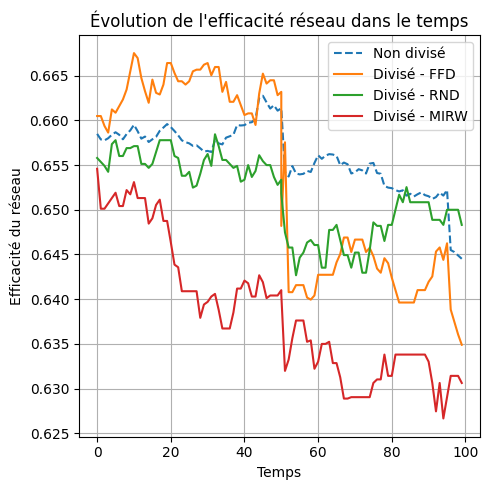

In [13]:

# Chargement du fichier CSV
df1 = pd.read_csv("resultats_swarm_simulation_FFD.csv")
df2 = pd.read_csv("resultats_swarm_simulation_RND.csv")
df3 = pd.read_csv("resultats_swarm_simulation_MIRW.csv")


# Nettoyage et conversion
cols = ["time", "efficacite", "cout", "robustesse"]
for df in [df1, df2, df3]:
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Dictionnaire pour facilité l'accès
dfs = {
    "FFD": df1,
    "RND": df2,
    "MIRW": df3
}

# Fonction pour tracer une métrique
def plot_metric(metric_name, ylabel, title):
    plt.figure(figsize=(5, 5))

    # Tracer la courbe non divisée (algo = none)
    
    df_non_div = df1[df1["algo"] == "none"]
    plt.plot(df_non_div["time"], df_non_div[metric_name], linestyle="--", label=f"Non divisé ")

    # Tracer la courbe divisée pour chaque algo
    for label, df in dfs.items():
        df_div = df[df["algo"] == label]
        plt.plot(df_div["time"], df_div[metric_name], label=f"Divisé - {label}")

    plt.xlabel("Temps")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
def boxplot_metric(metric_name, ylabel, title):
    plt.figure(figsize=(5, 5))
    
    data = []
    labels = []

    # Ajouter le cas "non divisé" une seule fois (depuis df1 par exemple)
    non_div_values = df1[df1["algo"] == "none"][metric_name].dropna()
    data.append(non_div_values)
    labels.append("Non divisé")

    # Ajouter les cas divisés pour chaque algo
    for label, df in dfs.items():
        div_values = df[df["algo"] == label][metric_name].dropna()
        data.append(div_values)
        labels.append(label)

    plt.boxplot(data, tick_labels=labels, patch_artist=True)
    plt.xticks(rotation=0)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()




# Tracer les trois métriques
plot_metric("robustesse", "Robustesse (connectivité)", "Évolution de la robustesse dans le temps")
plot_metric("cout", "Coût de routage", "Évolution du coût de routage dans le temps")
plot_metric("efficacite", "Efficacité du réseau", "Évolution de l'efficacité réseau dans le temps")





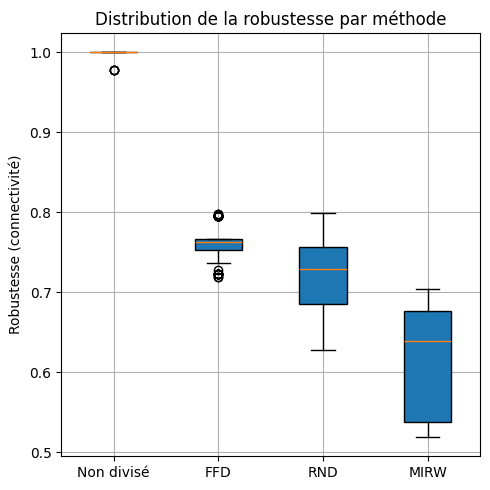

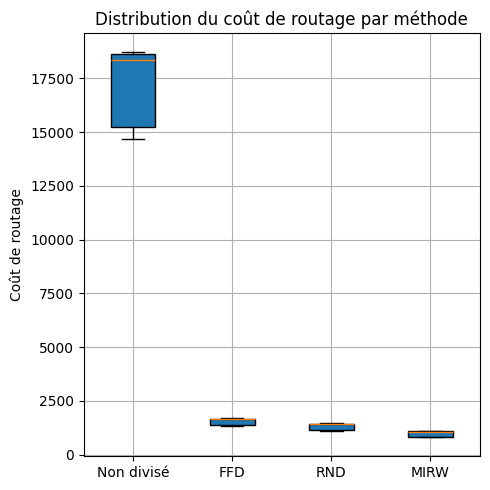

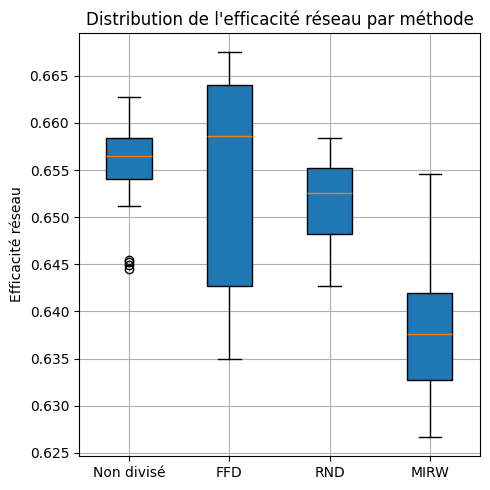

In [14]:
# Tracer les boxplots
boxplot_metric("robustesse", "Robustesse (connectivité)", "Distribution de la robustesse par méthode")
boxplot_metric("cout", "Coût de routage", "Distribution du coût de routage par méthode")
boxplot_metric("efficacite", "Efficacité réseau", "Distribution de l'efficacité réseau par méthode")
